# Amazon Reviews Sentiment Analysis

In [161]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2 #open zipped files
import gc #garbage ollector - keep track of all objects in memory

#NLP packages
import nltk.corpus
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from textblob import TextBlob
import re
import string

import warnings
warnings.filterwarnings("ignore")

In [25]:
train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

In [26]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [27]:
# clean the older variables
del train_file, test_file
gc.collect()

301

In [28]:
raw_data = pd.read_csv('Reviews.csv',encoding='utf8',error_bad_lines=False)
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_data.shape))
print (raw_data.info())

The shape of the  data is (row, column):(568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


In [29]:
from wordcloud import WordCloud

def wc(data,bgcolor,title):
    plt.figure(figsize = (50,50))
    wc = WordCloud(background_color = bgcolor, max_words = 2000, random_state=42, max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [30]:
raw_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [32]:
raw_data.shape

(568454, 10)

568454 rows and 10 columns

## Data Wrangling 
#### NLP: 
stemming, lemmatization, tokenization, stop word removal, frequency analysis. 

In [50]:
#check for null values
raw_data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [53]:
data = raw_data.copy()
data['Summary']=data['Summary'].fillna('Missing')

In [55]:
data.Summary.head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [56]:
data.Text.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [58]:
# concatenate text and summary
data['reviews']=data['Text']+data['Summary']
data=data.drop(['Text', 'Summary'], axis=1)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,reviews
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy at a great price. There was a wid...


## Exploratory Data Analysis

### Features
- ID: Row ID
- Product ID: Unique identifier for the product
- User ID: Unique identifier for the user
- Profile Name: Profile name of the user
- Helpfulness Numerator: Number of users who found the review helpful
- Helpfulness Denominator: Number of users who indicated whether they found the reivew helpful or not 
- Score: Rating between 1 and 5
- Time: Timestamp for the reviews
- Summary: Brief summary of review
- Text: Text of the review

In [99]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
reviews                   object
HelpfulnessScore          object
dtype: object

### Helpfulness Numerator

In [63]:
## Helpfulness Numerator
data['HelpfulnessNumerator'].describe()

count    568454.000000
mean          1.743817
std           7.636513
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64

There appears to be a extremely high number, an outlier = 866.

In [78]:
data[data['HelpfulnessNumerator']>2]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,reviews
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,If you are looking for the secret ingredient i...
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,One of my boys needed to lose some weight and ...
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,The Strawberry Twizzlers are my guilty pleasur...
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,My daughter loves twizzlers and this shipment ...
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,McCann's Instant Oatmeal is great if you must ...
...,...,...,...,...,...,...,...,...,...
568423,568424,B001FPT1WM,A1R3ERCRDIAV91,S. Hobbs,7,7,5,1262822400,"I bought this candy for my son, who spent time..."
568436,568437,B000NY4SAG,A3ODWHC3EMMWTT,"K. Brennan ""Baking fool""",10,10,5,1229731200,"In the past, I would have to buy a large quant..."
568437,568438,B000NY4SAG,A1RKKPSXF9QIZF,"Allen ""RcDriver""",4,4,5,1233792000,Ammonium bicarbonate in a nice little package....
568438,568439,B000NY4SAG,A3M89SF0SSOGBK,"Robert Goode ""GrampaG""",3,3,5,1316995200,If you haven't ever used Ammonium Bicarbonate ...


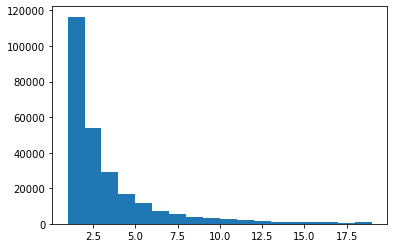

In [80]:
plt.hist(np.clip(data['HelpfulnessNumerator'], 0, 20),bins=np.arange(1,20));

### Helpfulness Denominator

In [62]:
## Helpfulness Denominator
data['HelpfulnessDenominator'].describe()

count    568454.00000
mean          2.22881
std           8.28974
min           0.00000
25%           0.00000
50%           1.00000
75%           2.00000
max         923.00000
Name: HelpfulnessDenominator, dtype: float64

In [81]:
data[data['HelpfulnessDenominator']>2]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,reviews
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,If you are looking for the secret ingredient i...
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,One of my boys needed to lose some weight and ...
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,The Strawberry Twizzlers are my guilty pleasur...
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,My daughter loves twizzlers and this shipment ...
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,McCann's Instant Oatmeal is great if you must ...
...,...,...,...,...,...,...,...,...,...
568436,568437,B000NY4SAG,A3ODWHC3EMMWTT,"K. Brennan ""Baking fool""",10,10,5,1229731200,"In the past, I would have to buy a large quant..."
568437,568438,B000NY4SAG,A1RKKPSXF9QIZF,"Allen ""RcDriver""",4,4,5,1233792000,Ammonium bicarbonate in a nice little package....
568438,568439,B000NY4SAG,A3M89SF0SSOGBK,"Robert Goode ""GrampaG""",3,3,5,1316995200,If you haven't ever used Ammonium Bicarbonate ...
568439,568440,B000NY4SAG,A34GDV49ZZQKXG,Donald M. Cook,0,5,4,1280102400,We need this for a recipe my wife is intereste...


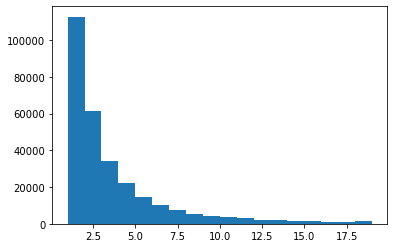

In [82]:
plt.hist(np.clip(data['HelpfulnessDenominator'], 0, 20),bins=np.arange(1,20));

### Helpfulness Rate

In [118]:
data['HelpfulnessRate'] = data['HelpfulnessNumerator']/data['HelpfulnessDenominator']
data['HelpfulnessRate']

0         1.0
1         NaN
2         1.0
3         1.0
4         NaN
         ... 
568449    NaN
568450    NaN
568451    1.0
568452    1.0
568453    NaN
Name: HelpfulnessRate, Length: 568454, dtype: float64

In [119]:
#check for null values
data['HelpfulnessRate'].isnull().sum()

270052

In [120]:
data['HelpfulnessRate']=data['HelpfulnessRate'].fillna('0')

In [121]:
data.HelpfulnessRate.describe()

count     568454
unique       952
top            0
freq      270052
Name: HelpfulnessRate, dtype: object

In [122]:
data['HelpfulnessRate']=pd.to_numeric(data['HelpfulnessRate'])

In [123]:
data.HelpfulnessRate.describe()

count    568454.000000
mean          0.407862
std           0.462068
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: HelpfulnessRate, dtype: float64

In [125]:
data.HelpfulnessRate.value_counts()

0.000000    303826
1.000000    183309
0.500000     21623
0.666667     10514
0.750000      6364
             ...  
0.920455         1
0.592593         1
0.362069         1
0.877551         1
0.978070         1
Name: HelpfulnessRate, Length: 951, dtype: int64

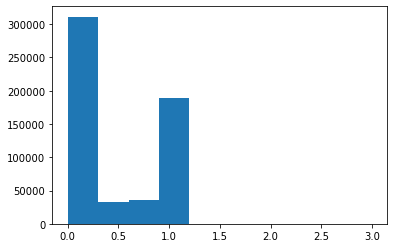

In [124]:
plt.hist(data['HelpfulnessRate']);

### Score

In [84]:
data['Score'].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

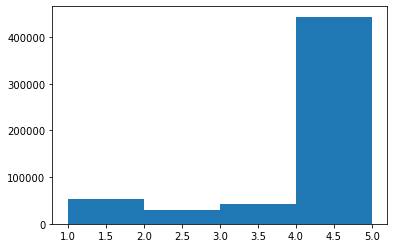

In [88]:
plt.hist(data.Score,bins=np.arange(1,6,1));

## Sentiment and HelpfulnessRate

In [165]:
pd.DataFrame(data.groupby('sentiment')['HelpfulnessRate'].mean())

,HelpfulnessRate
sentiment,
Negative,0.395239
Neutral,0.355267
Positive,0.415249


## Sentiment Polarity and Subjectivity 

### Sentiment

In [126]:
#sentiment value based on rating ('Score')
def sent(row):
    if row['Score'] == 3.0:
        val = 'Neutral'
    elif row['Score'] == 1.0 or row['Score'] == 2.0:
        val = 'Negative'
    elif row['Score'] == 4.0 or row['Score'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [128]:
data['sentiment'] = data.apply(sent, axis=1)
data.head() 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,reviews,HelpfulnessScore,sentiment,HelpfulnessRate
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,I have bought several of the Vitality canned d...,1.0,Positive,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Product arrived labeled as Jumbo Salted Peanut...,0.0,Negative,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,This is a confection that has been around a fe...,1.0,Positive,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,If you are looking for the secret ingredient i...,1.0,Negative,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy at a great price. There was a wid...,0.0,Positive,0.0


In [129]:
data['sentiment'].value_counts()

Positive    443777
Negative     82037
Neutral      42640
Name: sentiment, dtype: int64

In [144]:
# extract 1000 random samples from data
comm = data.sample(2000)
comm.shape

(2000, 12)

In [131]:
# calculate the Sentiment Polarity and Subjectivity
polarity=[] # list for the polarity of the comments
subjectivity=[] # list for the subjectivity of the comments
for i in comm['Text'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)

In [132]:
comm['polarity']=polarity
comm['subjectivity']=subjectivity

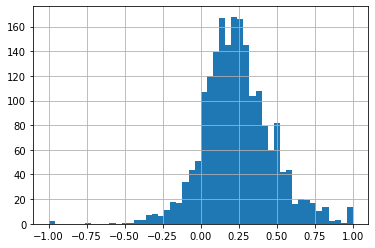

In [133]:
comm.polarity.hist(bins=50)

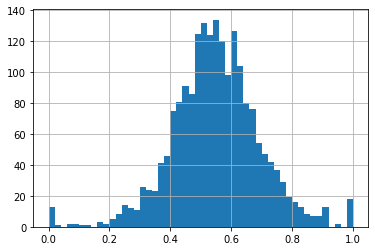

In [134]:
comm.subjectivity.hist(bins=50)

In [135]:
#Displaying the POSITIVE comments
df_positive = comm[comm.polarity==1]
df_positive[['ProfileName','Summary','Text']].head(10)

,ProfileName,Summary,Text
35420,Lao T. Sue,Great Mustard,"This is an excellent spicy mustard, and I get ..."
380378,saleh,very good,"Excellent service, and packaging is excellent...."
337722,summer,melt.....,I loved the chocolate when I tried it in a fri...
11071,"Yvette A. Walters ""EV""",DEEP RIVER POTATO CHIPS,THEY ARE DELICIOUS NOT SALTY YOU CAN SIT AND E...
224696,Grace Johnson,The Best Pepper mix ever!,Paula Deen 3.05-oz. The Lady & Son's Pepper Mi...
240766,Mark Twain,Incredibly good!,These are delicious. If you are concerned abo...
460506,FishFace,Addicting & delicious!,"Man, where has this stuff been all my life? I ..."
462619,Chicago,Great for cake pops!,These candies worked great for coating cake po...
279716,Scrappy,GREAT.,Wish they sold this all year. It is the best s...
519003,Lynda D Wright,great candy,zotz's are the best candies.i order a box of 4...


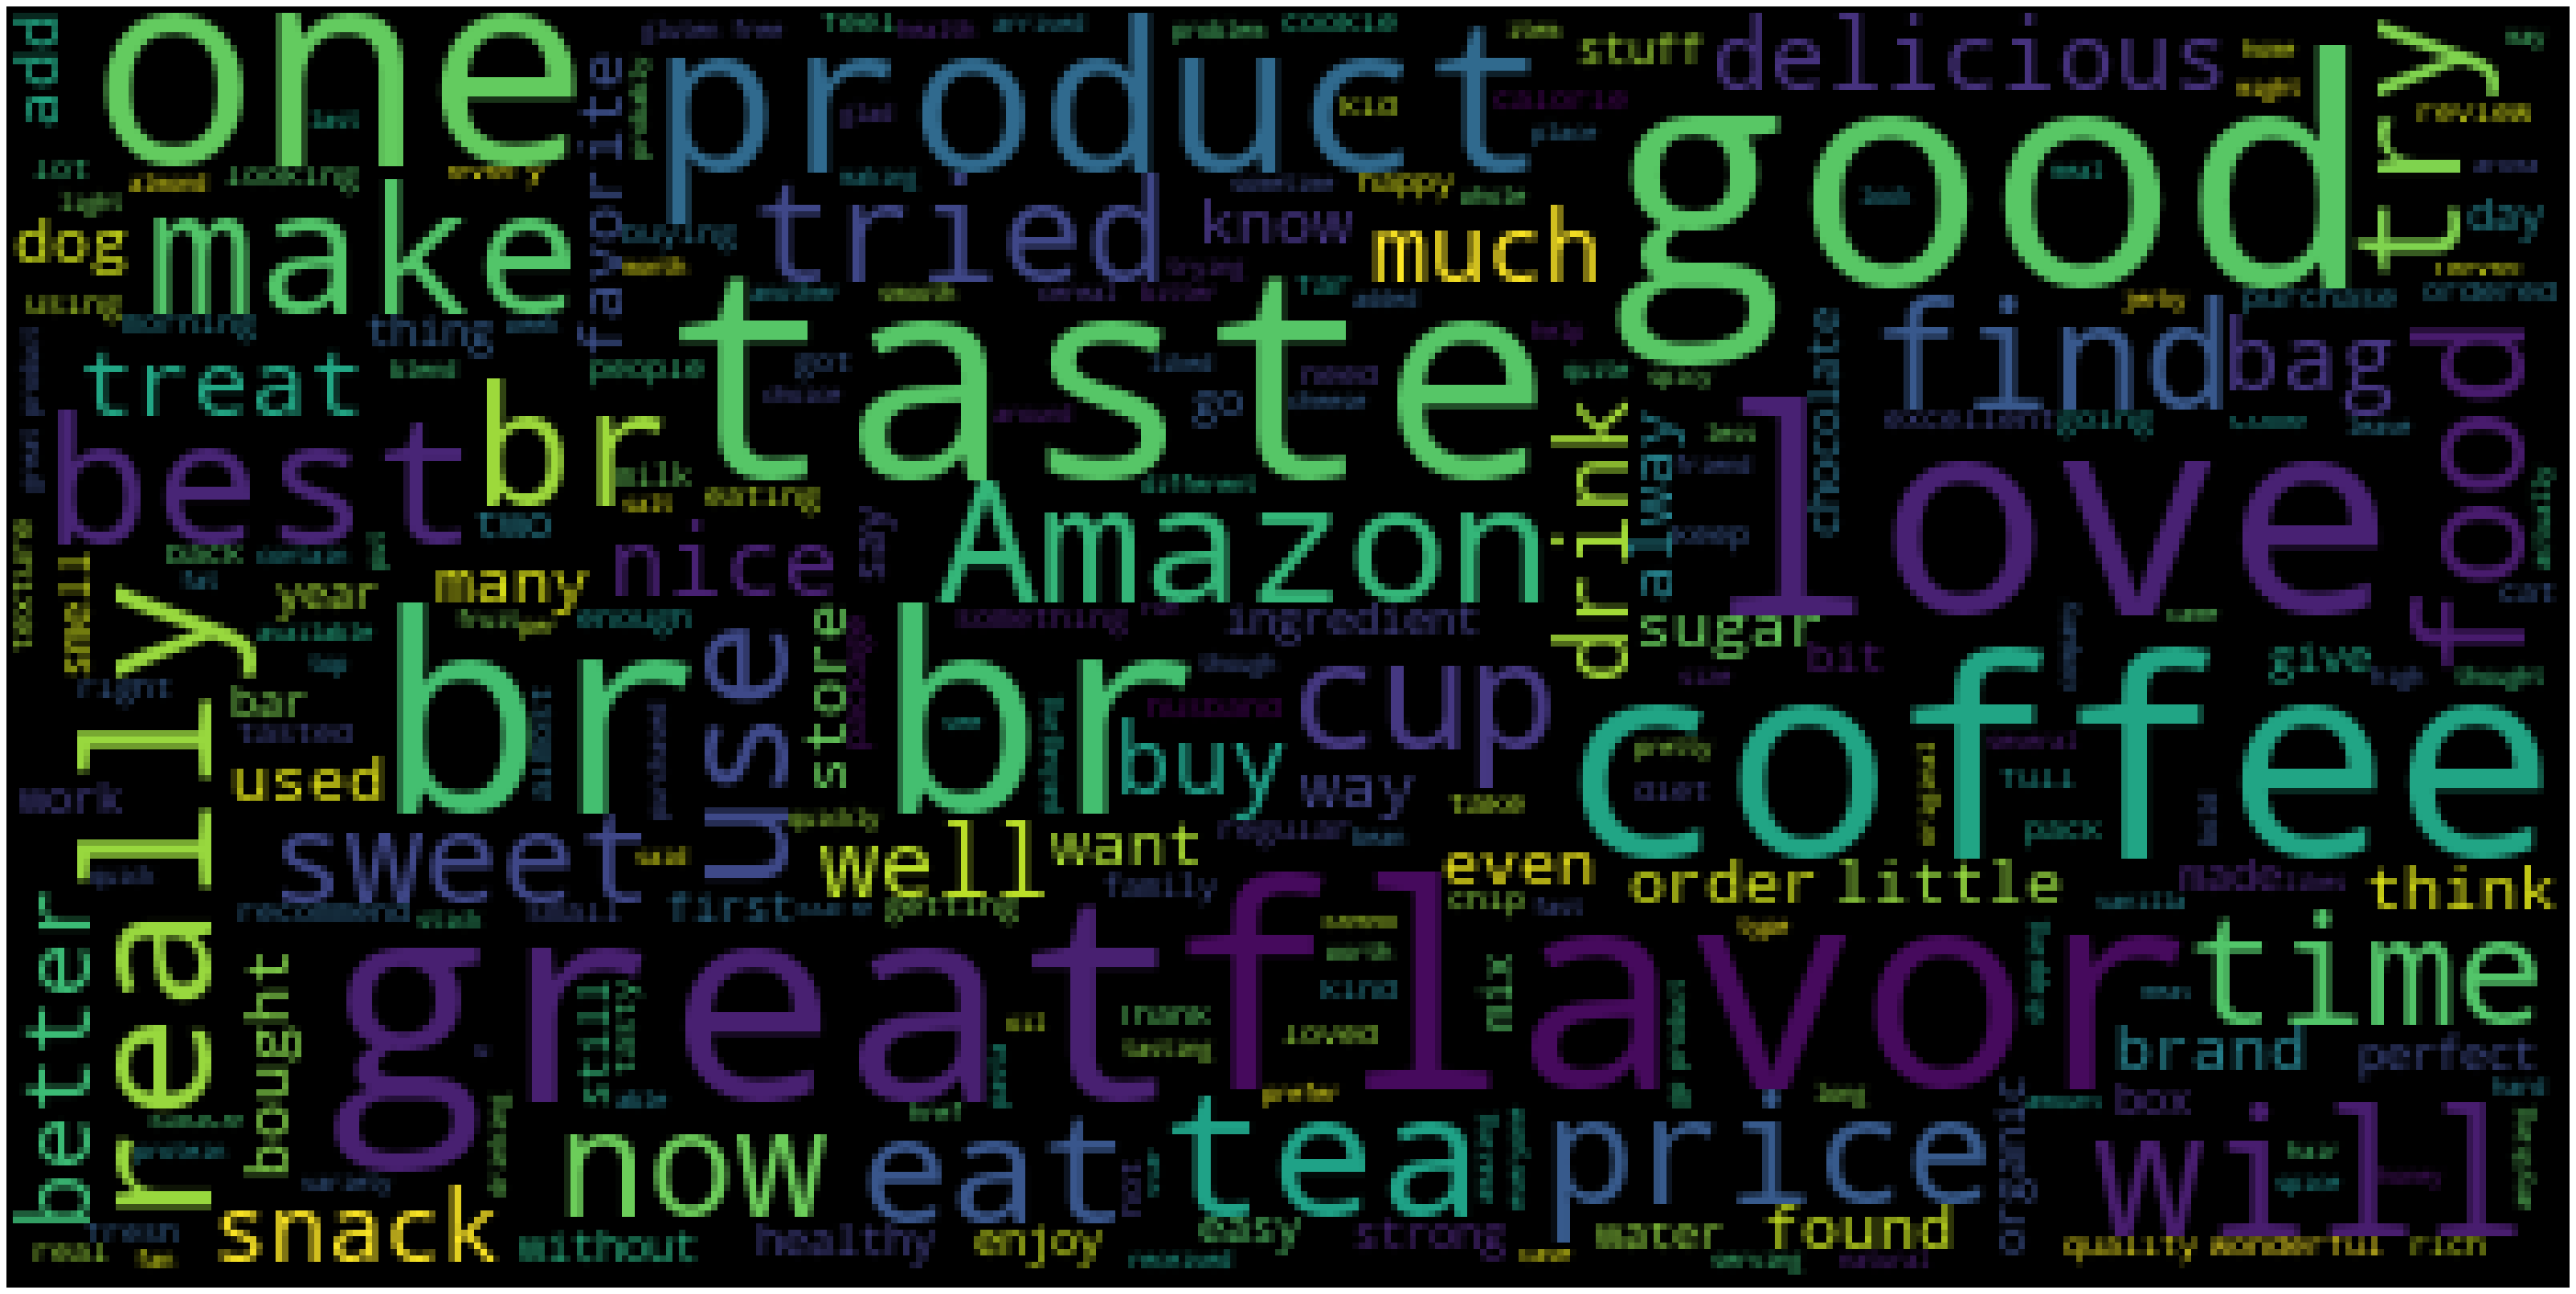

In [136]:
wc(comm['Text'][comm.polarity>0.20],'black','Common Words' )

In [137]:
#Displaying the NEGATIVE comments
df_positive = comm[comm.polarity==-1]
df_positive[['ProfileName','Summary','Text']].head(10)

,ProfileName,Summary,Text
561553,W. Reynolds,These are bad,Try the bacon mints if your going for a gag gi...
113005,Molly Yarber,Disgusting,These chips are nasty. I thought someone had ...


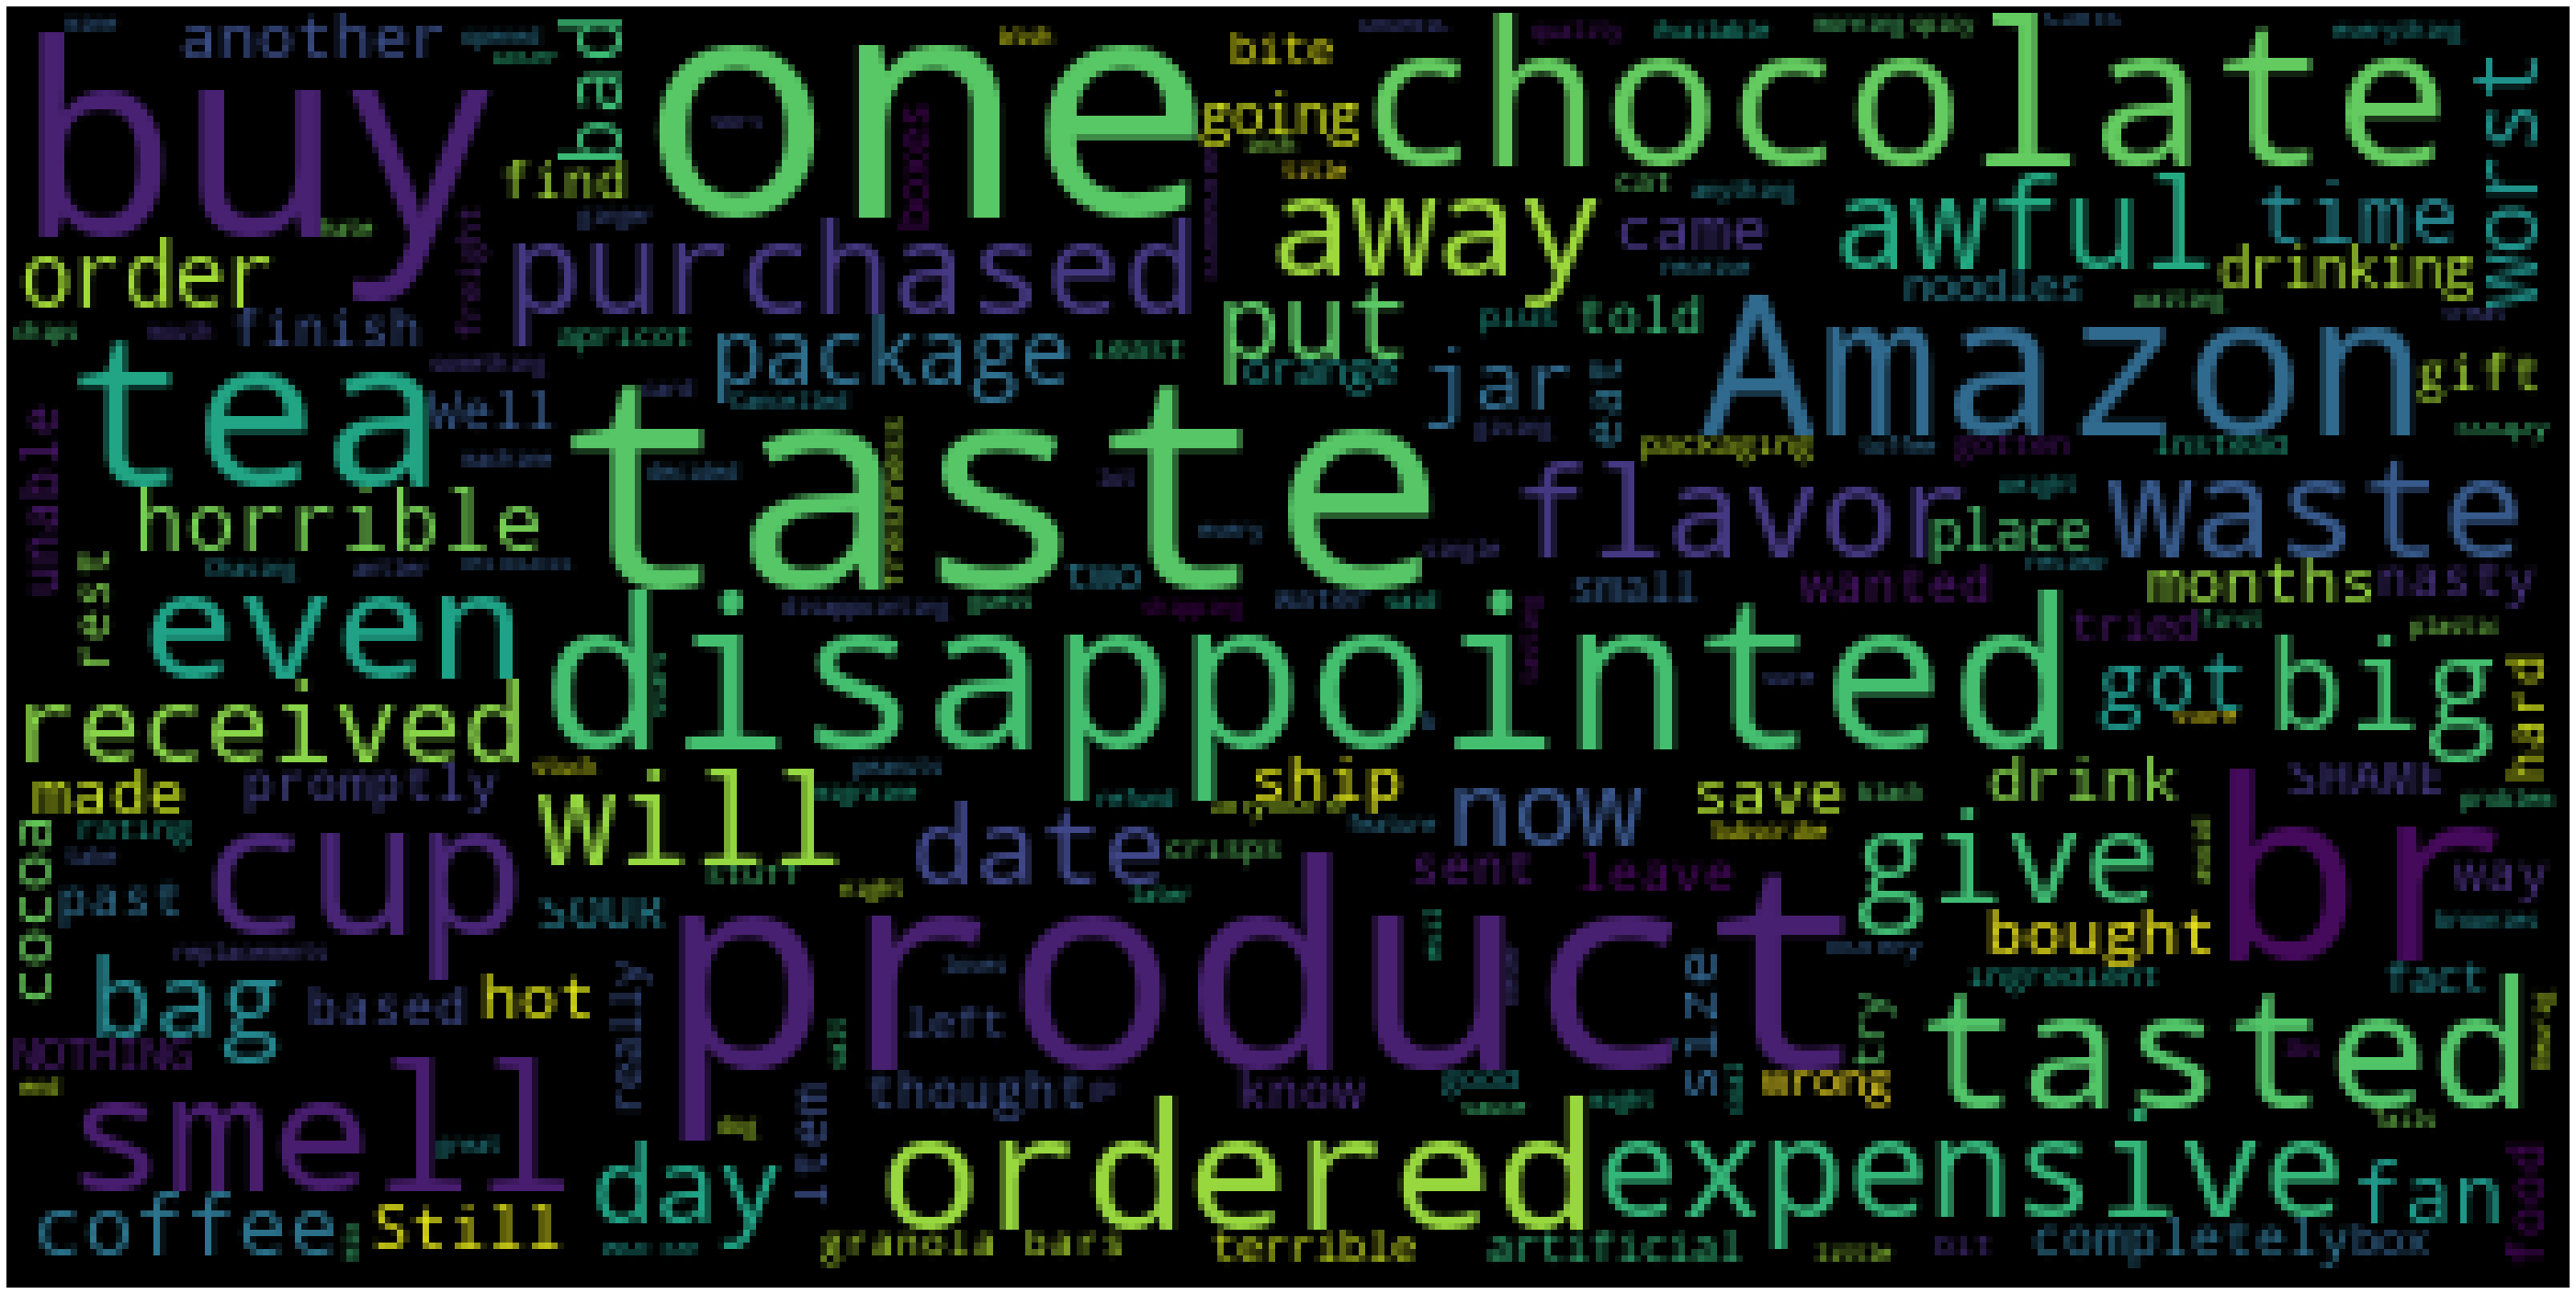

In [138]:
wc(comm['Text'][comm.polarity<-0.2],'black','Common Words' )

In [139]:
#Displaying the NEUTRAL comments
df_positive = comm[comm.polarity==0]
df_positive[['ProfileName','Summary','Text']].head(10)

,ProfileName,Summary,Text
142537,C. Coen,world King candy cigarettes,I bought the world king candy cigarettes from ...
130733,biruta,exellent,"exellent coffee,exellent price,and exellent se..."
346630,"A. French ""Mag Diva""",Use this product often,Really got tired of buying this product in the...
538814,J. Ramos,Great for my kids,This is a really great snack for kids. The fa...
270662,"Emil A. Peterson ""diabetic foodie""",AWSOME PASTA!,BEING A DIABETIC THIS PASTA IS HEAVEN. I COULD...
138145,wade,NO NO NO,My cat did not like these at all!!! Even tried...
524570,D. Allen,Amazon needs to work on quantities shipped,Ordered pack of 12. Got 1. Amazon did fix is...
135877,"I ove You ""Your Friend""",I called the OU and they are not Pas Yisroel,A friend of mine bought for my children these ...
274917,Bobbi Cara,best treats,My toy poodle loves these treats to the extent...
567751,Dale Borja,This hits the spot!,"Sometimes, I'd rather have cocoa instead of co..."


 0.500000    29
 0.000000    25
 1.000000    13
 0.400000    11
 0.250000    11
             ..
 0.267778     1
-0.122276     1
 0.391667     1
 0.067857     1
-0.060000     1
Name: polarity, Length: 1592, dtype: int64

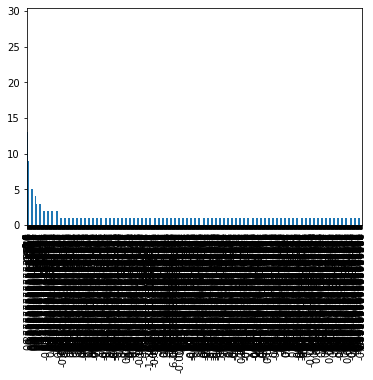

In [141]:
comm.polarity.value_counts().plot.bar()
comm.polarity.value_counts()

In [142]:
#Converting the polarity values from continuous to categorical
comm['polarity'][comm.polarity==0]= 0
comm['polarity'][comm.polarity > 0]= 1
comm['polarity'][comm.polarity < 0]= -1

In [143]:
comm

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,polarity,subjectivity
269801,269802,B000RZDLD6,A1E20A8LFD7KFW,"C. Andia ""csa""",0,0,1,1329609600,CAN'T COUNT,"I did order two of these items, but they only ...",1.0,0.800000
310323,310324,B008JKTH2A,A1648PNP0S8G07,CocoRosieFan,3,4,2,1296000000,Too Sweet,I've had other Kind bars and this one is okay ...,1.0,0.522024
515479,515480,B004TJD73U,A3QDUJ7VIE3NR,K. Peterson,0,0,3,1330560000,Good transaction,This was a good transaction but while Amazing ...,1.0,0.800000
525953,525954,B0088K31P0,A24NRYYZ5T56DH,Mary,1,1,5,1312243200,Turmeric,This product is amazing and has a good quality...,1.0,0.697778
542516,542517,B000E18CVE,A1K97IXF026J36,J. Lin,0,7,1,1255910400,Disgusting,This reminds me of dirty socks. Its a pretty ...,-1.0,0.570000
...,...,...,...,...,...,...,...,...,...,...,...,...
154383,154384,B004Q89W2Y,A2EHXYZZAA3WWM,PeterJames,0,0,5,1308873600,Great Tea - Great Price,Great roasted tea with a nice nutty characteri...,1.0,0.689583
504160,504161,B004IRCHQG,AEVQ9YS16FM9,Terrie S. Bailey,0,0,1,1299283200,Couldn't believe how bad it was . . .,Don't buy Millstone in the K-cups! We've used ...,1.0,0.471429
205291,205292,B001BORBHO,A3NO05U8A7GKF5,luvthgirls,3,3,5,1268006400,Life-changing Product,I've purchased Wellness before: my border coll...,1.0,0.513333
437404,437405,B002GWSAKM,A1QTUMSYNTGEDY,A. Holladay,11,13,1,1265414400,"Great product, but arrived in horrible conditi...",I love Rice Dream and have been using it for a...,-1.0,0.380556


## Clean punctuations in text 

In [162]:
# clean the text
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [163]:
data['reviews']=data['reviews'].apply(lambda x:review_cleaning(x))
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,reviews,HelpfulnessScore,sentiment,HelpfulnessRate
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,i have bought several of the vitality canned d...,1.0,Positive,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,product arrived labeled as jumbo salted peanut...,0.0,Negative,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,this is a confection that has been around a fe...,1.0,Positive,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,if you are looking for the secret ingredient i...,1.0,Negative,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy at a great price there was a wide...,0.0,Positive,0.0
